## Libraries

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
import skimage.measure
import numpy as np
import gym

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Functions

In [33]:
def preprocess(rgb_array):
    '''
    Takes 3D RGB tensor and consolidates to 2D Gray-scale tensor.
    '''
    transform = rgb_array[30:194,:,:]  ## crop
    gray = np.dot(transform[...,:3], [0.2989, 0.5870, 0.1140])  ## convert RGB to Gray Scale using Matlab's numbers
    downsample = skimage.measure.block_reduce(gray, (2,2), np.max)  ## downsampling (aka max pooling)
    return downsample

def experience_replay(C, DQ, seq_init, action, reward, seq_update, gamestatus):
    '''
    Inputs:
        C = capacity of experience replay (how big window should be)
        DQ = deque object
        seq_init = preprocessed frame before next action taken
        action = action taken
        reward = reward given action
        seq_update = preprocessed frame after action taken (new observation)
        gamestatus = whether end of game or not
    Output:
        updated DQ
    '''
    DQ.append((seq_init, action, reward, seq_update, gamestatus))
    if len(DQ) > C:
        DQ.popleft()
    return DQ

def epsilon_generator(start=1, stop=0.1, num=10):
    '''
    a generator that linearly anneals epsilon, which is the prob that a random action is taken
    '''
    test = 0
    epsilon = start
    step = (start - stop) / (num - 1)
    while epsilon >= stop and test < num:    
        yield epsilon
        epsilon -= step
        test += 1
    else:
        yield stop

## CNN Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 8)  ## Conv2d(nChannels, filters, kernel)
        self.conv2 = nn.Conv2d(16, 32, 4)
        self.fc1 = nn.relu(32 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.F.relu(self.conv1(x))
        x = self.F.relu(self.conv2(x))
        x = x.view(-1, 32 * 4 * 4)  ## reshape 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## CNN Setup

In [ ]:
cnn = CNN()
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.RMSprop(cnn.params, 
                          lr=learning_rate, 
                          alpha=0.99, 
                          eps=1e-08, 
                          weight_decay=0, 
                          momentum=0, 
                          centered=False)

## DQN

[ALGORITHM STEPS]

Initialize replay memory D to capacity N  
Initialize action-value function Q with random weights  
for episode = 1, M do  
    Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)  
    for t = 1, T do  
        With probability  select a random action at  
        otherwise select a_t = maxa Q∗(φ(st), a; θ)  
        Execute action a_t in emulator and observe reward rt and image xt+1  
        Set st+1 = s_t, a_t, xt+1 and preprocess φt+1 = φ(s_t+1)  
        Store transition (φt, a_t, r_t, φt+1) in D  
        Sample random minibatch of transitions (φ_j , a_j , r_j , φj+1) from D  
        Set y_j = r_j (for terminal φ_j+1)  
                 r_j + γ maxa0 Q(φ_j+1, a0; θ) (for non-terminal φ_j+1)  
        Perform a gradient descent step on (yj − Q(φj , aj ; θ))^2 according to equation 3  
    end for  
end for

#### Atari Emulator

In [ ]:
env = gym.make('Breakout-v0')

#### Game Variables

In [ ]:
nb_games = 5  ## number of games to play
time_steps = 500  ## max number of time steps per game

#### 'Experience Replay' Variables

In [ ]:
N = int(1e6)  ## capacity
D = deque()  ## deque object

#### Reinforcement Learning Variables

In [ ]:
anneal_tracker = 0  ## tally of how many total iterations have passed
anneal_stop = 1000  ## nb of steps until annealing stops
gen_epsilon = epsilon_generator(start=1, stop=0.1, num=anneal_stop)  ## Prob(choosing random action) w/linear annealing
discount = 0.9  ## on future rewards

#### Training

In [ ]:
for episode in range(nb_games):
    frames = []  ## empty list to capture mini-batch of frames
    gamestatus = 'nonterminal'
    raw_frame = env.reset()  ## raw initial frame
    seq_init = preprocess(raw_frame)  ## preprocessed initial sequence 
    
    for t in range(time_steps):
        
        # show game in real-time
        env.render()
        
        # linearly anneal epsilon (prob of selecting random action)
        if anneal_tracker <= anneal_stop:
            epsilon = next(gen_epsilon)
        print('epsilon:', epsilon)
        anneal_tracker += 1
        
        # take agent-based action every 4 time steps; otherwise push action forward w/out agent computing
        if t%4 == 0:
            action = env.action_space.sample() # take a random action
            #action = env.action_space.sample() if np.random.binomial(n=1, p=epsilon, size=1) else action w/max Q-value
            #print('action =', action)
        
        # feedback from emulator
        observation, reward, done, info = env.step(action)
        
        # preprocess new observation after action    
        seq_update = preprocess(observation)
        
        # mini-batch setup
        if t%4 == 3  or done:
            frameTensor = np.stack(frames)  ## makes arrays callable to feed into CNN
            print('t:', t, '\n', frameTensor.shape)  ## should be 4x82x80 unless 'done'
            frames = []  ## clear mini-batch
        else:
            frames.append(seq_update)
        
        # stop if out of lives
        if done:
            gamestatus = 'terminal'
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            print('*step: ', t, '| gamestatus: ', gamestatus, '| len(D):', len(D), 
                  '| init != update:', (D[len(D)-1][0] != D[len(D)-1][3]).sum())
            break
        else:
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            print('step:', t, '| gamestatus:', gamestatus, '| len(D):', len(D), 
                  '| init != update:',(D[len(D)-1][0] != D[len(D)-1][3]).sum())
    
        
        # mini-batch sample of experience replay for ConvNet
        D_size = len(D)
        idx = np.random.choice(range(D_size), size=min(D_size, 32), replace=False)
        # calculate target
        for i in idx:
            if D[i][4] == 'terminal':
                target = D[i][2] + 100
            else:
                #target = sample[i][2] + discount*(to be completed)
                target = D[i][2]
            #print('step: ', i, 'gamestatus: ', D[4], 'reward: ', D[2])
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # feedforward
        outputs = net(frameTensor)
        # calculate loss
        loss = criterion(outputs, targets)
        # backprop
        loss.backward()
        # update network weights
        optimizer.step()
        
        # set new observation as initial sequence
        seq_init = seq_update
        
        
        #print('final target =', target)
    #print( (D[len(D)-1][0] != D[len(D)-1][3]).sum())
    #print(D)

# EXAMPLE

### Get Frames

In [85]:
frames = []
rewards = []
nb_frames = 500
env = gym.make('Breakout-v0')
env.reset()
for t in range(nb_frames):
    env.render()
    action = env.action_space.sample() # take a random action
    observation, reward, done, info = env.step(action)
    frames.append(preprocess(observation))
    if t%4 == 3 or done:
        frameTensor = np.stack(frames)
        minibatch = Variable(torch.Tensor(frameTensor))  ## convert to torch Variable data type
        print('t:', t, '\n', minibatch)
        frames = []
    if done:
        break

[2017-08-23 15:55:01,363] Making new env: Breakout-v0


t: 3 
 Variable containing:
(0 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(1 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(2 ,.,.)

t: 51 
 Variable containing:
(0 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(1 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(2 ,.,.

t: 103 
 Variable containing:
(0 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(1 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(2 ,.,

t: 155 
 Variable containing:
(0 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(1 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(2 ,.,

t: 211 
 Variable containing:
(0 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(1 ,.,.) = 
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
              ...                ⋱                ...             
  141.9858  141.9858  141.9858  ...   141.9858  141.9858  141.9858
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520
  127.2934  127.2934  127.2934  ...   110.2520  110.2520  110.2520

(2 ,.,

0

### Show Preprocessed Data Frames

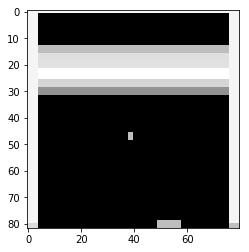

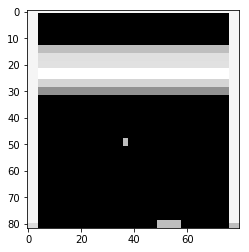

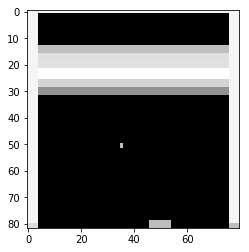

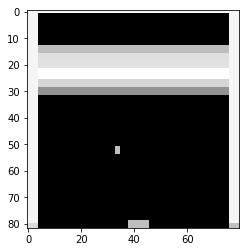

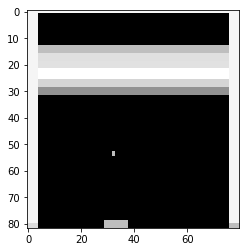

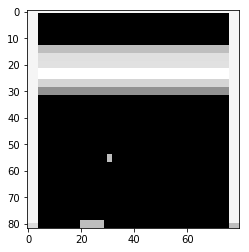

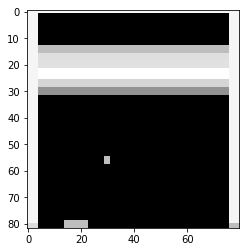

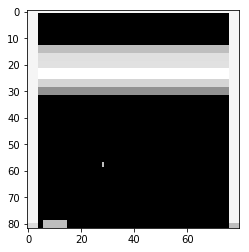

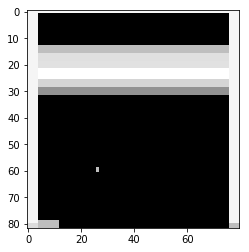

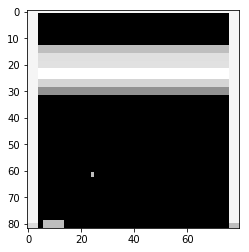

In [35]:
for frame in frames:
    plt.imshow(frame, cmap = plt.get_cmap('gray'))
    plt.show()

### Frame Dimensions

In [ ]:
frame.shape

# EXPERIMENTAL

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.197
[1,  4000] loss: 1.833
[1,  6000] loss: 1.647
[1,  8000] loss: 1.540
[1, 10000] loss: 1.495
[1, 12000] loss: 1.471
[2,  2000] loss: 1.385
[2,  4000] loss: 1.373
[2,  6000] loss: 1.319
[2,  8000] loss: 1.318
[2, 10000] loss: 1.292
[2, 12000] loss: 1.314
Finished Training


In [8]:
data[0].shape

torch.Size([4, 3, 32, 32])

In [76]:
Variable(torch.Tensor(tmp))

Variable containing:
(0 ,.,.) = 
  0.5565  2.4071  0.3015  0.1093
  0.5916  1.4238 -0.4388 -0.0195
 -0.0378  0.9490 -2.0921  0.1322

(1 ,.,.) = 
 -1.4330 -0.2264  0.3551 -2.8850
 -0.2492 -0.2994  1.1674 -1.8444
  1.2853  0.8776  0.1166 -0.0821

(2 ,.,.) = 
  1.1372  0.1498  0.6576 -0.1474
 -0.3907 -1.6076  2.0637 -0.5001
 -0.1197 -0.5335  0.8072 -1.3731

(3 ,.,.) = 
  0.2756 -0.3928 -0.6694 -0.6579
 -0.3271  1.1550 -0.7291 -0.6396
 -0.4053 -0.5088 -0.7313  2.8191

(4 ,.,.) = 
 -0.5386 -0.8071 -2.8312  0.2614
  0.6833 -0.4833 -0.5399 -0.1882
  2.2383  1.4219  2.0247 -1.1333

(5 ,.,.) = 
 -0.4758  0.9115 -0.0338 -0.2573
 -0.2318  0.8819  1.2049 -1.2846
 -0.5842 -0.8353 -0.3366 -0.4674

(6 ,.,.) = 
 -1.1941  0.6771 -0.8836 -0.2519
  0.8340  0.3207 -0.1826  0.0885
 -0.8666  0.3411 -0.6750 -0.5934

(7 ,.,.) = 
  0.7055  0.0651  0.1474  1.0435
 -2.1357  0.2798 -1.1071  0.8378
 -0.4890 -0.2038 -0.9833  0.3800

(8 ,.,.) = 
 -1.0331  0.7846 -0.3711 -0.0570
 -0.6386  1.3893 -1.0645  0.6708
 -0.2

# Legacy

In [ ]:
# Atari emulator
env = gym.make('Breakout-v0')

# game variables
nb_games = 5  ## number of games to play
time_steps = 500  ## max number of time steps per game

# experience replay variables
N = int(1e6)  ## capacity
D = deque()  ## deque object

# RL vars
anneal_tracker = 0  ## tally of how many total iterations have passed
anneal_stop = 1000  ## nb of steps until annealing stops
gen_epsilon = epsilon_generator(start=1, stop=0.1, num=anneal_stop)  ## Prob(choosing random action) w/linear annealing
discount = 0.9  ## on future rewards

# CNN setup
cnn = CNN()
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.RMSprop(cnn.params, 
                          lr=learning_rate, 
                          alpha=0.99, 
                          eps=1e-08, 
                          weight_decay=0, 
                          momentum=0, 
                          centered=False)

# algorithm
for episode in range(nb_games):
    gamestatus = 'nonterminal'
    raw_frame = env.reset()  ## raw initial frame
    seq_init = preprocess(raw_frame)  ## preprocessed initial sequence 
    
    for t in range(time_steps):
        
        # show game in real-time
        env.render()
        
        # linearly anneal epsilon (prob of selecting random action)
        if anneal_tracker <= anneal_stop:
            epsilon = next(gen_epsilon)
        print('epsilon:', epsilon)
        anneal_tracker += 1
        
        # take agent-based action every 4 time steps; otherwise push action forward w/out agent computing
        if t%4 == 0:
            action = env.action_space.sample() # take a random action
            #action = env.action_space.sample() if np.random.binomial(n=1, p=epsilon, size=1) else action w/max Q-value
            #print('action =', action)
        
        # feedback from emulator
        observation, reward, done, info = env.step(action)
        
        # preprocess new observation after action    
        seq_update = preprocess(observation)
        
        # stop if out of lives
        if done:
            gamestatus = 'terminal'
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            print('*step: ', t, '| gamestatus: ', gamestatus, '| len(D):', len(D), 
                  '| init != update:', (D[len(D)-1][0] != D[len(D)-1][3]).sum())
            break
        else:
            # update experience replay
            experience_replay(C=N, DQ = D, seq_init=seq_init, 
                              action=action, reward=reward, 
                              seq_update=seq_update, gamestatus=gamestatus)
            print('step:', t, '| gamestatus:', gamestatus, '| len(D):', len(D), 
                  '| init != update:',(D[len(D)-1][0] != D[len(D)-1][3]).sum())
    
        
        # mini-batch sample of experience replay for ConvNet
        D_size = len(D)
        idx = np.random.choice(range(D_size), size=min(D_size, 32), replace=False)
        # calculate target
        for i in idx:
            if D[i][4] == 'terminal':
                target = D[i][2] + 100
            else:
                #target = sample[i][2] + discount*(to be completed)
                target = D[i][2]
            #print('step: ', i, 'gamestatus: ', D[4], 'reward: ', D[2])
        # SGD update
        #update weights
        # set new observation as initial sequence
        seq_init = seq_update
        #print('final target =', target)
    #print( (D[len(D)-1][0] != D[len(D)-1][3]).sum())
    #print(D)